<a href="https://colab.research.google.com/github/Amirbn73/Air-Pollution-Prediction-PM2.5/blob/main/ANN_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from time import time

In [2]:
file = files.upload()

Saving testData.csv to testData.csv
Saving trainData.csv to trainData.csv


In [3]:
!git clone https://github.com/PetraVidnerova/rbf_keras.git

Cloning into 'rbf_keras'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 124 (delta 2), reused 3 (delta 0), pack-reused 116
Receiving objects: 100% (124/124), 25.19 KiB | 2.52 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [4]:
from sklearn.model_selection import KFold
import keras
from keras import layers
import tensorflow
from rbf_keras import kmeans_initializer
from keras.optimizers import RMSprop

In [39]:
from keras import backend as K
from tensorflow.keras.layers import Layer
from keras.initializers import RandomUniform, Initializer, Constant
import numpy as np


class InitCentersRandom(Initializer):
    """ Initializer for initialization of centers of RBF network
        as random samples from the given data set.

    # Arguments
        X: matrix, dataset to choose the centers from (random rows
          are taken as centers)
    """

    def __init__(self, X):
        self.X = X

    def __call__(self, shape, dtype=None):
      assert shape[1] == self.X.shape[1]
      idx = np.random.randint(self.X.shape[0], size=shape[0])

	# type checking to access elements of data correctly
      if type(self.X) == np.ndarray:
          return self.X[idx, :]
      elif type(self.X) == pd.core.frame.DataFrame:
          return self.X.iloc[idx, :]


class RBFLayer(Layer):
    """ Layer of Gaussian RBF units.

    # Example

    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X),
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```


    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas

    """

    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.init_betas = betas
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0)
        else:
            self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(
                                         value=self.init_betas),
                                     # initializer='ones',
                                     trainable=True)

        super(RBFLayer, self).build(input_shape)

    def call(self, x):

        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp(-self.betas * K.sum(H**2, axis=1))

        # C = self.centers[np.newaxis, :, :]
        # X = x[:, np.newaxis, :]

        # diffnorm = K.sum((C-X)**2, axis=-1)
        # ret = K.exp( - self.betas * diffnorm)
        # return ret

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [7]:
dfTrain = pd.read_csv('trainData.csv')

In [8]:
dfTest = pd.read_csv('testData.csv')

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
dfTrain.head()

,Daily_Maximum_Air_Temperature,Daily_Minimum_Air_Temperature,Daily_Rainfall_Total,Daily_Maximum_Gust_Speed,Daily_Mean_Wind_Speed,PM2_5,Year,Month,Dis2MR
0,10.089966,4.687183,1.537404,22.684994,8.938454,9.198598,2020.0,Jan,315.0
1,10.089937,4.686582,1.537582,22.682667,8.935701,9.198660,2020.0,Jan,315.0
2,10.089907,4.685930,1.537774,22.680147,8.932724,9.198797,2020.0,Jan,315.0
3,10.089874,4.685228,1.537981,22.677433,8.929516,9.199010,2020.0,Jan,315.0
4,10.089840,4.684475,1.538203,22.674519,8.926075,9.199301,2020.0,Jan,315.0


In [11]:
dfTest.head()

,Daily_Maximum_Air_Temperature,Daily_Minimum_Air_Temperature,Daily_Rainfall_Total,Daily_Maximum_Gust_Speed,Daily_Mean_Wind_Speed,PM2_5,Year,Month,Dis2MR
0,10.011533,4.247788,1.641221,21.823470,8.079857,9.577205,2020.0,Jan,315.0
1,10.011165,4.246223,1.641590,21.821150,8.077766,9.578631,2020.0,Jan,315.0
2,10.010802,4.244675,1.641956,21.818848,8.075686,9.580137,2020.0,Jan,315.0
3,10.010447,4.243146,1.642316,21.816563,8.073618,9.581725,2020.0,Jan,315.0
4,10.010096,4.241639,1.642672,21.814295,8.071561,9.583395,2020.0,Jan,315.0


In [12]:
dfTrain.columns = dfTrain.columns.to_series().apply(lambda x: x.replace('Daily_', ''))

In [13]:
dfTest.columns = dfTest.columns.to_series().apply(lambda x: x.replace('Daily_', ''))

In [14]:
# Create dummy variables for the 'Month' column with drop_first=True
df_dummies = pd.get_dummies(dfTrain['Month'], prefix='Month', drop_first=True)

# Concatenate the dummy variables with the original DataFrame
dfTrain = pd.concat([dfTrain, df_dummies], axis=1)

# Drop the original 'Month' column since we now have dummy variables
dfTrain.drop('Month', axis=1, inplace = True)

dfTrain.head()

,Maximum_Air_Temperature,Minimum_Air_Temperature,Rainfall_Total,Maximum_Gust_Speed,Mean_Wind_Speed,PM2_5,Year,Dis2MR,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
0,10.089966,4.687183,1.537404,22.684994,8.938454,9.198598,2020.0,315.0,0,0,0,1,0,0,0,0,0,0,0
1,10.089937,4.686582,1.537582,22.682667,8.935701,9.198660,2020.0,315.0,0,0,0,1,0,0,0,0,0,0,0
2,10.089907,4.685930,1.537774,22.680147,8.932724,9.198797,2020.0,315.0,0,0,0,1,0,0,0,0,0,0,0
3,10.089874,4.685228,1.537981,22.677433,8.929516,9.199010,2020.0,315.0,0,0,0,1,0,0,0,0,0,0,0
4,10.089840,4.684475,1.538203,22.674519,8.926075,9.199301,2020.0,315.0,0,0,0,1,0,0,0,0,0,0,0


In [15]:
# Create dummy variables for the 'Month' column with drop_first=True
ds_dummies = pd.get_dummies(dfTest['Month'], prefix='Month', drop_first=True)

# Concatenate the dummy variables with the original DataFrame
dfTest = pd.concat([dfTest, ds_dummies], axis=1)

# Drop the original 'Month' column since we now have dummy variables
dfTest.drop('Month', axis=1, inplace = True)

dfTest.head()

,Maximum_Air_Temperature,Minimum_Air_Temperature,Rainfall_Total,Maximum_Gust_Speed,Mean_Wind_Speed,PM2_5,Year,Dis2MR,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
0,10.011533,4.247788,1.641221,21.823470,8.079857,9.577205,2020.0,315.0,0,0,0,1,0,0,0,0,0,0,0
1,10.011165,4.246223,1.641590,21.821150,8.077766,9.578631,2020.0,315.0,0,0,0,1,0,0,0,0,0,0,0
2,10.010802,4.244675,1.641956,21.818848,8.075686,9.580137,2020.0,315.0,0,0,0,1,0,0,0,0,0,0,0
3,10.010447,4.243146,1.642316,21.816563,8.073618,9.581725,2020.0,315.0,0,0,0,1,0,0,0,0,0,0,0
4,10.010096,4.241639,1.642672,21.814295,8.071561,9.583395,2020.0,315.0,0,0,0,1,0,0,0,0,0,0,0


In [16]:
correlation_matrix = dfTrain.corr()

# Display the correlation matrix
correlation_matrix

,Maximum_Air_Temperature,Minimum_Air_Temperature,Rainfall_Total,Maximum_Gust_Speed,Mean_Wind_Speed,PM2_5,Year,Dis2MR,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
Maximum_Air_Temperature,1.000000,0.946367,-0.105793,-0.308916,-0.250909,-0.338625,-1.089240e-01,2.929565e-04,3.886583e-01,-3.659916e-01,-3.218776e-01,-4.047917e-01,4.048250e-01,3.339123e-01,-2.203412e-01,1.372327e-01,-2.151279e-01,-8.637643e-03,3.027378e-01
Minimum_Air_Temperature,0.946367,1.000000,0.089959,-0.300615,-0.208008,-0.463779,-5.649981e-02,4.568720e-03,4.604027e-01,-2.508652e-01,-2.901246e-01,-3.367229e-01,4.245189e-01,3.447370e-01,-2.765169e-01,-4.149265e-03,-1.927844e-01,7.614203e-02,2.914155e-01
Rainfall_Total,-0.105793,0.089959,1.000000,0.298374,0.177557,-0.372427,3.294372e-02,-3.299070e-03,-4.168182e-02,1.178316e-01,1.435071e-01,1.610860e-01,2.783365e-02,8.894996e-02,-1.957198e-01,-1.404387e-01,-2.595237e-01,5.609482e-01,-1.577720e-01
Maximum_Gust_Speed,-0.308916,-0.300615,0.298374,1.000000,0.879756,-0.197464,-3.945960e-01,2.988097e-02,-9.188854e-02,-4.778659e-02,5.622945e-01,-4.446819e-03,-1.242412e-01,-1.808285e-01,2.099143e-01,1.337007e-01,-2.079070e-01,1.218810e-01,-2.433594e-01
Mean_Wind_Speed,-0.250909,-0.208008,0.177557,0.879756,1.000000,-0.148127,-2.952261e-01,6.885912e-02,-5.971017e-02,-2.853324e-02,4.979508e-01,1.488299e-02,-8.899430e-02,-1.124529e-01,1.755959e-01,1.118392e-02,-1.426420e-01,3.353503e-02,-1.596768e-01
PM2_5,-0.338625,-0.463779,-0.372427,-0.197464,-0.148127,1.000000,4.571594e-02,1.010399e-03,-3.071531e-01,-9.289126e-02,5.158275e-03,1.267237e-01,-2.248202e-01,-1.196616e-01,2.967513e-01,-1.455766e-01,2.985962e-01,-3.311463e-01,-3.009603e-03
Year,-0.108924,-0.056500,0.032944,-0.394596,-0.295226,0.045716,1.000000e+00,-2.424686e-14,2.619455e-12,2.578419e-12,-4.217617e-12,-5.423293e-12,5.486380e-12,1.410048e-13,-7.163607e-14,-9.336857e-13,2.044348e-12,-9.311568e-13,1.118164e-12
Dis2MR,0.000293,0.004569,-0.003299,0.029881,0.068859,0.001010,-2.424686e-14,1.000000e+00,1.632383e-15,3.657039e-15,-5.601234e-16,-1.506263e-15,5.878291e-16,3.390191e-16,-1.511119e-15,-2.731466e-15,1.454889e-15,-4.145125e-16,1.060976e-15
Month_Aug,0.388658,0.460403,-0.041682,-0.091889,-0.059710,-0.307153,2.619455e-12,1.632383e-15,1.000000e+00,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02
Month_Dec,-0.365992,-0.250865,0.117832,-0.047787,-0.028533,-0.092891,2.578419e-12,3.657039e-15,-9.090909e-02,1.000000e+00,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02


In [17]:
filtered_df = correlation_matrix[correlation_matrix > 0.5]

# Display the filtered DataFrame
filtered_df

,Maximum_Air_Temperature,Minimum_Air_Temperature,Rainfall_Total,Maximum_Gust_Speed,Mean_Wind_Speed,PM2_5,Year,Dis2MR,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
Maximum_Air_Temperature,1.000000,0.946367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Minimum_Air_Temperature,0.946367,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rainfall_Total,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.560948,NaN
Maximum_Gust_Speed,NaN,NaN,NaN,1.000000,0.879756,NaN,NaN,NaN,NaN,NaN,0.562295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mean_Wind_Speed,NaN,NaN,NaN,0.879756,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PM2_5,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dis2MR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Month_Aug,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Month_Dec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
dfTrain.head()

,Maximum_Air_Temperature,Minimum_Air_Temperature,Rainfall_Total,Maximum_Gust_Speed,Mean_Wind_Speed,PM2_5,Year,Dis2MR,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
0,10.089966,4.687183,1.537404,22.684994,8.938454,9.198598,2020.0,315.0,0,0,0,1,0,0,0,0,0,0,0
1,10.089937,4.686582,1.537582,22.682667,8.935701,9.198660,2020.0,315.0,0,0,0,1,0,0,0,0,0,0,0
2,10.089907,4.685930,1.537774,22.680147,8.932724,9.198797,2020.0,315.0,0,0,0,1,0,0,0,0,0,0,0
3,10.089874,4.685228,1.537981,22.677433,8.929516,9.199010,2020.0,315.0,0,0,0,1,0,0,0,0,0,0,0
4,10.089840,4.684475,1.538203,22.674519,8.926075,9.199301,2020.0,315.0,0,0,0,1,0,0,0,0,0,0,0


In [19]:
dfTrain.drop(['Maximum_Air_Temperature', 'Maximum_Gust_Speed'], axis = 1, inplace = True)

In [20]:
dfTest.drop(['Maximum_Air_Temperature', 'Maximum_Gust_Speed'], axis = 1, inplace = True)

In [21]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
import keras

In [22]:
dfTrain.describe()

,Minimum_Air_Temperature,Rainfall_Total,Mean_Wind_Speed,PM2_5,Year,Dis2MR,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
count,785928.000000,785928.000000,785928.000000,785928.000000,785928.0,785928.000000,785928.000000,785928.000000,785928.000000,785928.000000,785928.000000,785928.000000,785928.000000,785928.000000,785928.000000,785928.000000,785928.000000
mean,7.642405,1.876134,6.127370,8.078708,2020.5,315.701729,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333
std,4.269131,1.135880,1.552594,2.496473,0.5,257.669020,0.276386,0.276386,0.276386,0.276386,0.276386,0.276386,0.276386,0.276386,0.276386,0.276386,0.276386
min,1.314331,0.058065,3.400001,3.709696,2020.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.848140,1.250211,5.032129,6.385108,2020.0,100.623060,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.477508,1.652020,5.887427,7.707471,2020.5,242.332410,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12.432158,2.651482,6.949762,9.275292,2021.0,478.356570,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,15.580551,5.219355,14.077190,14.924164,2021.0,1323.489700,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
scaler = MinMaxScaler((0,1))
# dfTrain['Maximum_Air_Temperature'] = scaler.fit_transform(dfTrain[['Maximum_Air_Temperature']])
dfTrain['Minimum_Air_Temperature'] = scaler.fit_transform(dfTrain[['Minimum_Air_Temperature']])
dfTrain['Rainfall_Total'] = scaler.fit_transform(dfTrain[['Rainfall_Total']])
# dfTrain['Maximum_Gust_Speed'] = scaler.fit_transform(dfTrain[['Maximum_Gust_Speed']])
dfTrain['Mean_Wind_Speed'] = scaler.fit_transform(dfTrain[['Mean_Wind_Speed']])
# ds['PM2_5'] = scaler.fit_transform(ds[['PM2_5']])
dfTrain['Dis2MR'] = scaler.fit_transform(dfTrain[['Dis2MR']])

In [24]:
scaler = MinMaxScaler((0,1))
# dfTest['Maximum_Air_Temperature'] = scaler.fit_transform(dfTest[['Maximum_Air_Temperature']])
dfTest['Minimum_Air_Temperature'] = scaler.fit_transform(dfTest[['Minimum_Air_Temperature']])
dfTest['Rainfall_Total'] = scaler.fit_transform(dfTest[['Rainfall_Total']])
# dfTest['Maximum_Gust_Speed'] = scaler.fit_transform(dfTest[['Maximum_Gust_Speed']])
dfTest['Mean_Wind_Speed'] = scaler.fit_transform(dfTest[['Mean_Wind_Speed']])
# ds['PM2_5'] = scaler.fit_transform(ds[['PM2_5']])
dfTest['Dis2MR'] = scaler.fit_transform(dfTest[['Dis2MR']])

In [25]:
X = dfTrain.drop('PM2_5',axis = 1)
y = dfTrain[['PM2_5']]

In [26]:
from sklearn.utils import shuffle

In [27]:
XTrain_shuffled, yTrain_shuffled = shuffle(X, y, random_state=42)

In [28]:
print(XTrain_shuffled.shape,yTrain_shuffled.shape)
XTrain_shuffled.head()

(785928, 16) (785928, 1)


,Minimum_Air_Temperature,Rainfall_Total,Mean_Wind_Speed,Year,Dis2MR,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
769499,0.266459,0.423064,0.342385,2021.0,0.000000,0,1,0,0,0,0,0,0,0,0,0
383368,0.148612,0.449131,0.331431,2020.0,0.608229,0,1,0,0,0,0,0,0,0,0,0
97681,0.156463,0.261210,0.371929,2020.0,0.048085,0,0,0,0,0,0,1,0,0,0,0
201906,0.791182,0.215593,0.163750,2020.0,0.136004,0,0,0,0,1,0,0,0,0,0,0
148681,0.519950,0.001188,0.325443,2020.0,0.076029,0,0,0,0,0,0,0,1,0,0,0


In [29]:
yTrain_shuffled.head()

,PM2_5
769499,6.906044
383368,7.350437
97681,8.681868
201906,4.339274
148681,7.468957


In [30]:
X_tr, _, y_tr, _ = train_test_split(XTrain_shuffled, yTrain_shuffled, test_size=0.2, random_state=42)

In [31]:
X_test = dfTest.drop('PM2_5',axis = 1)
y_test = dfTest[['PM2_5']]

In [32]:
XTest_shuffled, yTest_shuffled = shuffle(X_test, y_test, random_state=42)

In [33]:
X_tst = XTest_shuffled[261060:]
y_tst = yTest_shuffled[261060:]

In [34]:
X_Val = XTest_shuffled[:100000]
y_Val = yTest_shuffled[:100000]

In [35]:
X_Test, _, y_Test, _ = train_test_split(X_tst, y_tst, test_size=0.5, random_state=42)

In [36]:
X_Test.shape, X_Val.shape, X_tr.shape

((130530, 16), (100000, 16), (628742, 16))

In [41]:
# kfold = KFold(n_splits = 1)
histories = []
rbfLayer = RBFLayer(10,
                      initializer= kmeans_initializer.InitCentersKMeans(X_tr),
                      betas = 2.0,
                      input_shape = ([16]))
ins_model = keras.models.Sequential()
ins_model.add(rbfLayer)
ins_model.add(layers.Dense(1))
ins_model.compile(loss = 'mae',
                    #'mean_squared_error',
                    optimizer = RMSprop())
# i = 0
# for train_index, val_index in kfold.split(X_tr):
  # i += 1
  # print(i)
# X_train, X_val = X_tr.iloc[train_index], X_tr.iloc[val_index]
# Y_train, Y_val = y_tr.iloc[train_index], y_tr.iloc[val_index]

  # rbfLayer = RBFLayer(10,
  #                     initializer= kmeans_initializer.InitCentersKMeans(x),
  #                     betas = 2.0,
  #                     input_shape = ([6]))
  # ins_model = keras.models.Sequential()
  # ins_model.add(rbfLayer)
  # ins_model.add(layers.Dense(1))
  # ins_model.compile(loss = 'mae',
  #                   #'mean_squared_error',
  #                   optimizer = RMSprop())
history = ins_model.fit(X_tr, y_tr,
                          epochs = 500,
                          batch_size = 1024,
                          validation_data = (X_Val, y_Val)
                          )
histories.append(history)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch 1/500
615/615 [==============================] - 4s 5ms/step - loss: 7.2708 - val_loss: 6.6423
Epoch 2/500
615/615 [==============================] - 3s 5ms/step - loss: 4.5704 - val_loss: 2.7184
Epoch 3/500
615/615 [==============================] - 4s 7ms/step - loss: 1.2902 - val_loss: 1.1893
Epoch 4/500
615/615 [==============================] - 3s 5ms/step - loss: 0.9241 - val_loss: 0.9599
Epoch 5/500
615/615 [==============================] - 3s 5ms/step - loss: 0.7311 - val_loss: 0.8466
Epoch 6/500
615/615 [==============================] - 4s 6ms/step - loss: 0.5367 - val_loss: 0.7458
Epoch 7/500
615/615 [==============================] - 4s 7ms/step - loss: 0.3987 - val_loss: 0.7383
Epoch 8/500
615/615 [==============================] - 4s 6ms/step - loss: 0.3379 - val_loss: 0.6959
Epoch 9/500
615/615 [==============================] - 3s 5ms/step - loss: 0.3121 - val_loss: 0.6549
Epoch 10/500
615/615 [==============================] - 4s 7ms/step - loss: 0.2707 - val_lo

In [42]:
y_pred = ins_model.predict(X_Test,
                           batch_size = 2048)
r2_score(y_Test, y_pred)

64/64 [==============================] - 1s 6ms/step


0.8558353099944268

In [43]:
mean_squared_error(y_Test, y_pred)

0.7742802771064493

In [44]:
mean_absolute_error(y_Test, y_pred)

0.5412809174935173

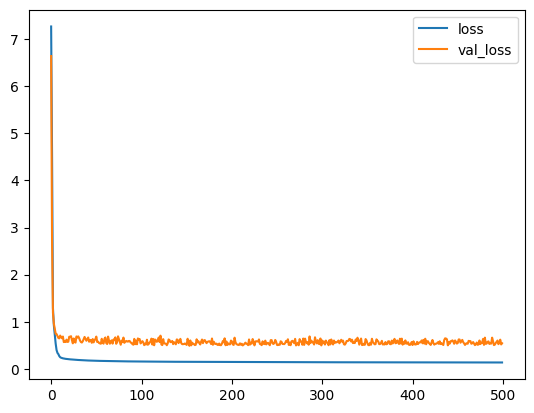

In [45]:
for i in histories:
  pd.DataFrame(i.history).plot()

In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
# del model

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

# Assuming X_train, y_train, X_val, y_val are your training and validation sets

mlp_model = MLPRegressor(hidden_layer_sizes=(200,100,70,20), learning_rate = 'adaptive', verbose = True, max_iter=10, random_state=42)

# Lists to store training and validation losses for each epoch
train_losses = []
val_losses = []

for epoch in range(500):  # adjust the number of epochs as needed
    # Train on the training set
    mlp_model.partial_fit(X_tr, y_tr)

    # Predict on the training set and calculate loss
    y_train_pred = mlp_model.predict(X_tr)
    train_loss = mean_absolute_error(y_tr, y_train_pred)
    train_losses.append(train_loss)

    # Predict on the validation set and calculate loss
    y_val_pred = mlp_model.predict(X_Val)
    val_loss = mean_absolute_error(y_Val, y_val_pred)
    val_losses.append(val_loss)

    # Print or log the training and validation losses for each epoch
    print(f'Epoch {epoch + 1}/{500} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}')

# Plot or analyze the training and validation losses over epochs if needed
# For example, if using matplotlib:
import matplotlib.pyplot as plt

plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(np.arange(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Iteration 1, loss = 0.27489390
Iteration 2, loss = 0.04270316
Iteration 3, loss = 0.03784543
Iteration 4, loss = 0.03406003
Iteration 5, loss = 0.03140248
Iteration 6, loss = 0.02944971
Iteration 7, loss = 0.02805213
Iteration 8, loss = 0.02682467
Iteration 9, loss = 0.02618796
Iteration 10, loss = 0.02485346
the model was run is 1083.8689105510712 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
mlp_model.score(X_Test, y_Test)

0.9862269179195358

In [ ]:
y_pred = mlp_model.predict(X_Test)
r2_score(y_Test, y_pred)

In [ ]:
mean_squared_error(y_Test, y_pred)

In [ ]:
mean_absolute_error(y_Test, y_pred)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(np.arange(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()